### Pennylane Intro to QSVT

**Aryan Bawa**  

In this notebook, I follow Pennylane.ai's intro to QSVT tutorial [here](https://pennylane.ai/qml/demos/tutorial_intro_qsvt) and make some notes about the process. 

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

The crux of QSVT is really the QSP step. Given a unitary matrix to encode and a By altering :math:$U(a)$ and :math:$S(\phi)$, keeping $a$ fixed and varying $\phi,$ the top-left corner of the resulting matrix is a polynomial transformation of $a:$    

$$ S(\phi_0)\prod_{k=1}^d U(a) S(\phi_k) = \begin{pmatrix}
    P(a) & *\\
    * & *
    \end{pmatrix}.$$

Every time $U(a)$ is multiplied, its entries are transformed into a polynomial of higher degree. By interweaving signal processing operators, the coefficients of the polynomial can be tuned. The main QSP theorem states that it is possible to find angles that implement a large class of complex polynomial transformations $P(a)$ with max degree and parity determined by the number of angles. The results of the theorem can be extended to show that using $d+1$ angles that implement any real polynomial of parity $d \text{mod} 2$ and maximum degree $d$. Therefore, there are multiple QSP sequences that can be used to implement real polynomials of indefinite parity. the qsvt() function in pennylane calculates the angle internally.


The first example pennylane uses is the encoding of Legendre polynomial $\frac{(5x^3 -3x)}{2}.$ This is done by putting the coefficients of the matrix in an array. This 1x5 matrix is made unitary via block encoding. 

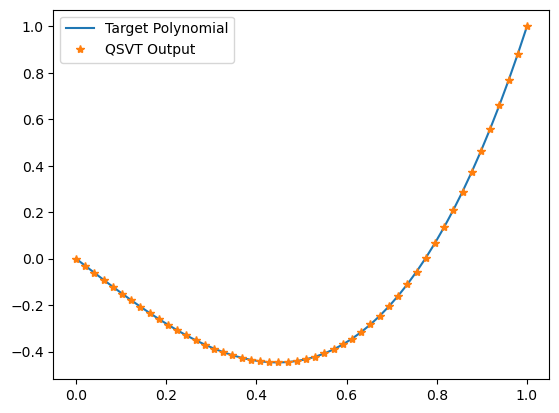

In [ ]:
# coefficients of polynomial in an array
target_poly = [0, -3 * 0.5, 0, 5 * 0.5]

def qsvt_output(a):
    # output matrix
    out = qml.matrix(qml.qsvt(a, target_poly, encoding_wires=[0], block_encoding="embedding"))
    return out[0,0] # top left element is the output

# 100 evenly spaced values for a between 0 and 1
a_vals = np.linspace(0, 1, 50) 
# compute the output for each value of a -> neglect small imaginary part with np.real
qsvt = np.real([qsvt_output(a) for a in a_vals])
# compute the target polynomial values for each a   
target = [np.polyval(target_poly[::-1], a) for a in a_vals]

# compare the qsvt output with the target polynomial
plt.plot(a_vals, target, label="Target Polynomial")
plt.plot(a_vals, qsvt, "*", label="QSVT Output")


plt.legend()
plt.show()

Notice how the QSVT essentially just approximates the target polynomial, sort of like a taylor approximation.

A few notes about the pennylane package itself - remember to go through the steps of setting up an environment.yml with a pip install, as this gives the most updated version of pennylane. Pennylane on the conda forge is pretty outdated. To do this, slap this into the bottom of the environment.yml file:

Generate environment.yml by running conda env export > environment.yml. Update environment or create new environment with conda env update -f environment.yml or conda env create -f environment.yml.

Continuing on with QSVT itself, 